# 决策树简介

&emsp;&emsp;他的概念非常简单，可以通过简单的图形了解其工作原理：
- （1）正方形代表判断模块；
- （2）椭圆形代表终止模块，表示已经得出结论，可以终止运行；
- （3）左右箭头称作分支，它可以到达另一个判断模块或终止模块；  
    k-近邻算法可以完成许多分类任务，但他最大的缺点就是无法给出数据内在的含义，决策树主要的优势在于数据形式非常容易理解；
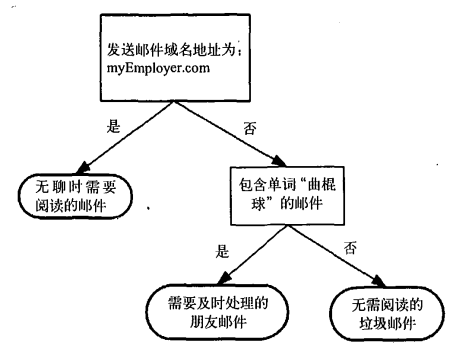

***
# 决策树的构造

- 优点：计算复杂度不高，输出结果易于理解，对中间值的缺失不敏感，可以处理不相关特征数据；
- 缺点：可能会产生过度匹配问题；
- 适用数据类型：数值型和标称型；

## 决策树一般流程

- （1）收集数据；
- （2）准备数据：树构造算法只适用于标称型数据，因此数值型数据必须离散化；
- （3）分析数据：构造树完成后，检查图形是否符合预期；
- （4）训练算法：构造树的数据结构；
- （5）测试算法：使用经验树计算错误率；
- （6）使用算法：适用于任何监督学习算法；

下图数据包含5个海洋生物，特征包括：不浮出水面是否可以生存；以及是否有蹼。可以将这些动物分为两类：鱼类和非鱼类。现在想要决定依据第一个特征还是第二个特征划分数据。必须采用量化的方法判断如何划分数据。
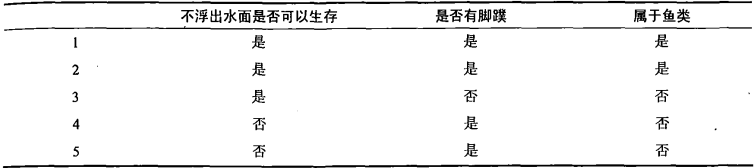

## 信息增益

&emsp;&emsp;在划分数据之前之后信息发生的变化称为信息增益，知道如何计算信息增益，我们就能计算每个特征值划分数据集获得的信息增益，获得信息增益最高的特征就是最好的选择。  
&emsp;&emsp;集合信息的度量方式称为香农熵或者简称为熵。  
&emsp;&emsp;熵定义为信息的期望值，在明晰这个概念之前，必须知道信息的定义。如果待分类事务可能划分在多个分类中，则符号xi的信息定义为：
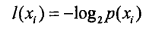
其中p(xi)是选择该分类的概率。  
&emsp;&emsp;为了计算熵，需要计算所有分类所有可能值包含的信息期望值，公式如下：
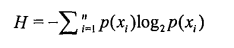
其中n是分类的数目。

In [1]:
#计算给定数据集的香农熵
import numpy as np
from math import log

def calcShannonEnt(dataSet):
    #数据集中实例的总数
    numEntries=len(dataSet)
    #创建数据字典
    labelCounts={}
    for featVec in dataSet:
        #将最后一列的数值作为键值
        currentLabel=featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel]=0
        labelCounts[currentLabel]+=1
    #香农熵
    shannonEnt=0.0
    for key in labelCounts:
        #使用所有类标签发生的频率计算类别出现的概率
        prob = float(labelCounts[key])/numEntries
        shannonEnt-=prob*log(prob,2)
    return shannonEnt

In [2]:
#简单的鱼鉴定数据集
def createDataSet():
    dataSet=[[1,1,'yes'],
            [1,1,'yes'],
            [1,0,'no'],
            [0,1,'no'],
            [0,1,'no']]
    labels=['no surfacing' , 'flippers']
    return dataSet,labels

In [3]:
#测试
myDat,labels=createDataSet()
calcShannonEnt(myDat)

0.9709505944546686

熵越高，则混合的数据也越多（度量数据集的无序程度）。

## 划分数据集

&emsp;&emsp;分类算法除了需要测量信心熵，还需要划分数据集，度量花费数据集的熵，以便判断当前是否正确地划分了数据集。
- （1）我们将对每个特征划分数据集的结果计算一次信息熵；
- （2）然后判断按照哪个特征划分数据集是最好的划分方式；

In [4]:
#按照给定的特征划分数据集
def splitDataSet(dataSet,axis,value):  #待划分的数据集、划分数据集的特征、特征的返回值
    retDataSet=[]
    #按照某个特征划分数据集时，就需要将所有符合要求的元素抽取出来
    for featVec in dataSet:
        #axis表示第几个特征，value则是特征返回的值
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [5]:
#extend（）和append（）的不同
a=[1,2,3]
b=[4,5,6]
c=[7,8,9]
a.append(b)
print(a)
b.extend(c)
print(b)

[1, 2, 3, [4, 5, 6]]
[4, 5, 6, 7, 8, 9]


In [6]:
myDat

[[1, 1, 'yes'], [1, 1, 'yes'], [1, 0, 'no'], [0, 1, 'no'], [0, 1, 'no']]

In [7]:
#第一个特征判断结果是1，划分
splitDataSet(myDat,0,1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

In [8]:
#第一个特征判断结果是0，划分
splitDataSet(myDat,0,0)

[[1, 'no'], [1, 'no']]

In [9]:
#选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet):
    #特征数减一为了更好地划分数据集
    numFeatures=len(dataSet[0])-1
    #基础熵
    baseEntropy=calcShannonEnt(dataSet)
    #最好的信息增益
    bestInfoGain=0.0
    #最好的特征划分
    bestFeature=-1
    
    for i in range(numFeatures):
        #创建唯一的分类标签列表
        featList=[example[i] for example in dataSet] #将数据集中所有第i个特征值或者所有可能存在的值写入新list
        uniqueVals=set(featList)
        newEntropy=0.0  #新熵值
        #计算每种划分方式的信息熵
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet,i,value)
            prob=len(subDataSet)/float(len(dataSet)) #子集占比
            newEntropy +=prob*calcShannonEnt(subDataSet)
        #信息增益
        infoGain = baseEntropy-newEntropy
        #计算最好的信息增益
        if (infoGain > bestInfoGain):
            bestInfoGain=infoGain
            bestFeature=i
    return bestFeature  #返回最好特征划分的索引值

In [10]:
chooseBestFeatureToSplit(myDat)
#第一个特征是最好用于划分数据集的特征

0

## 递归构建决策树